In [1]:
import numpy
import math
from scipy import integrate
from matplotlib import pyplot
%matplotlib inline

In [2]:
class Panel:
    """Contains information related to one panel."""
    def __init__(self, xa, ya, xb, yb):
        """Creates a panel.
        
        Arguments
        ---------
        xa, ya -- Cartesian coordinates of the first end-point.
        xb, yb -- Cartesian coordinates of the second end-point.
        """
        self.xa, self.ya = xa, ya
        self.xb, self.yb = xb, yb
        
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2       # control-point (center-point)
        self.length = math.sqrt((xb-xa)**2+(yb-ya)**2)     # length of the panel
        
        # orientation of the panel (angle between x-axis and panel's normal)
        if xb-xa <= 0.:
            self.beta = math.acos((yb-ya)/self.length)
        elif xb-xa > 0.:
            self.beta = math.pi + math.acos(-(yb-ya)/self.length)
        
        # location of the panel
        if self.beta <= math.pi:
            self.loc = 'extrados'
        else:
            self.loc = 'intrados'
        
        self.sigma = 0.                             # source strength
        self.vt = 0.                                # tangential velocity
        self.cp = 0.                                # pressure coefficient

In [3]:
class Freestream:
    """Freestream conditions."""
    def __init__(self, u_inf, alpha):
        """Sets the freestream conditions.
        
        Arguments
        ---------
        u_inf -- Farfield speed (default 1.0).
        alpha -- Angle of attack in degrees (default 0.0).
        """
        self.u_inf = u_inf
        self.alpha = alpha*math.pi/180          # degrees --> radians

In [4]:
def define_panels(x, y, N):
    """Discretizes the geometry into panels using input arrays for the ends of the panels.
    
    Arguments
    ---------
    x, y -- Cartesian coordinates of the panel endpoints.
    N - number of panels.
    
    Returns
    -------
    panels -- Numpy array of panels.
    """
    x_ends, y_ends = x, y
    panels = numpy.empty(N, dtype=object)
    
    for i in range(N):
        panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i+1], y_ends[i+1])
    
    return panels

In [5]:
def integral(x, y, panel, dxdz, dydz):
    """Evaluates the contribution of a panel at one point.
    
    Arguments
    ---------
    x, y -- Cartesian coordinates of the point.
    panel -- panel which contribution is evaluated.
    dxdz -- derivative of x in the z-direction.
    dydz -- derivative of y in the z-direction.
    
    Returns
    -------
    Integral over the panel of the influence at one point.
    """
    def func(s):
        return ( ((x - (panel.xa - math.sin(panel.beta)*s))*dxdz 
                  + (y - (panel.ya + math.cos(panel.beta)*s))*dydz)
                / ((x - (panel.xa - math.sin(panel.beta)*s))**2 
                   + (y - (panel.ya + math.cos(panel.beta)*s))**2) )
    return integrate.quad(lambda s:func(s), 0., panel.length)[0]

In [6]:
def build_rhs(panels, freestream):
    """Builds the RHS of the linear system.
    
    Arguments
    ---------
    panels -- array of panels.
    freestream -- farfield conditions.
    
    Returns
    -------
    b -- 1D array ((N+2), N is the number of panels).
    """
    N = len(panels)
    b = numpy.empty(N+2,dtype=float)
    
    for i, panel in enumerate(panels):
        b[i] = - freestream.u_inf * math.cos(freestream.alpha - panel.beta)
    
    b[N] = -freestream.u_inf*( math.sin(freestream.alpha-panels[0].beta)
                              +math.sin(freestream.alpha-panels[(N/2)-1].beta) )
    b[N+1] = -freestream.u_inf*( math.sin(freestream.alpha-panels[(N/2)].beta)
                              +math.sin(freestream.alpha-panels[N-1].beta) )
    
    return b

In [7]:
def get_tangential_velocity(panels, freestream, gamma, At):
    """Computes the tangential velocity on the surface.
    
    Arguments
    ---------
    panels -- array of panels.
    freestream -- farfield conditions.
    gamma -- circulation density.
    """
    N = len(panels)
    
    var = numpy.append([panel.sigma for panel in panels], gamma)
    
    b = freestream.u_inf * numpy.sin([freestream.alpha - panel.beta for panel in panels])
    vt = numpy.dot(At, var) + b
    
    for i, panel in enumerate(panels):
        panel.vt = vt[i]

In [8]:
def get_pressure_coefficient(panels, freestream):
    """Computes the surface pressure coefficients.
    
    Arguments
    ---------
    panels -- array of panels.
    freestream -- farfield conditions.
    """
    for panel in panels:
        panel.cp = 1.0 - (panel.vt/freestream.u_inf)**2


In [9]:
def get_velocity_field(panels, freestream, X, Y):
    """Returns the velocity field.
    
    Arguments
    ---------
    panels -- array of panels.
    freestream -- farfield conditions.
    X, Y -- mesh grid.
    """
    Nx, Ny = X.shape
    u, v = numpy.empty((Nx, Ny), dtype=float), numpy.empty((Nx, Ny), dtype=float)
    
    for i in range(Nx):
        for j in range(Ny):
            u[i,j] = freestream.u_inf*math.cos(freestream.alpha)\
                     + 0.5/math.pi*sum([p.sigma*integral(X[i,j], Y[i,j], p, 1, 0) for p in panels])
            v[i,j] = freestream.u_inf*math.sin(freestream.alpha)\
                     + 0.5/math.pi*sum([p.sigma*integral(X[i,j], Y[i,j], p, 0, 1) for p in panels])
    
    return u, v

In [10]:
def build_matrix(panels):
    """Builds the matrix of the linear system.
    
    Arguments
    ---------
    panels -- array of panels.
    
    Returns
    -------
    A -- (N+2)x(N+2) matrix (N is the number of panels).
    """
    N = len(panels)
    ak = numpy.empty((2,N+2), dtype=float)
    a_t = numpy.zeros((N,N+2), dtype=float)
    at1, at2 = numpy.zeros((N), dtype=float), numpy.zeros((N), dtype=float)
    av = numpy.empty((N,2), dtype=float)
    A = numpy.empty((N+2,N+2), dtype=float)
    
    Bn = numpy.empty((N,N), dtype=float)
    numpy.fill_diagonal(Bn, 0.0)
    
    An = source_matrix(panels)
    
    for i, p_i in enumerate(panels):
        for j, p_j in enumerate(panels):
            if i != j:
                Bn[i,j] = -0.5/numpy.pi*integral(p_i.xc, p_i.yc, p_j, numpy.sin(p_i.beta), -numpy.cos(p_i.beta))
    
    for i, p_i in enumerate(panels):
        av[i,0] = numpy.sum(Bn[i,:N/2])
        av[i,1] = numpy.sum(Bn[i,N/2:])
                
    for i, p_i in enumerate(panels):
        at1[i] = numpy.sum(An[i,:N/2])
        at2[i] = numpy.sum(An[i,N/2:])
    
    a_t[:N,:N] = Bn
    a_t[:,-2], a_t[:,-1] = -at1, -at2
    
    ak[0,:], ak[1,:] = a_t[0,:] + a_t[N/2-1,:], a_t[N/2,:] + a_t[-1,:]
    
    A[0:N,0:N], A[0:N,N:], A[N:,:] = An, av, ak
    
    return A, a_t

In [11]:
def source_matrix(panels):
    """Builds the source matrix.
    
    Arguments
    ---------
    panels -- array of panels.
    
    Returns
    -------
    A -- NxN matrix (N is the number of panels).
    """
    N = len(panels)
    A = numpy.empty((N, N), dtype=float)
    numpy.fill_diagonal(A, 0.5)
    
    for i, p_i in enumerate(panels):
        for j, p_j in enumerate(panels):
            if i != j:
                A[i,j] = 0.5/math.pi*integral(p_i.xc, p_i.yc, p_j, math.cos(p_i.beta), math.sin(p_i.beta))
    
    return A

In [12]:
x_wing,y_wing = numpy.loadtxt(open("../AeroPython/lessons/resources/MainFoil_N=100.csv","rb"),delimiter=",",skiprows=0,unpack=True) 
x_flap,y_flap = numpy.loadtxt(open("../AeroPython/lessons/resources/FlapFoil_N=100.csv","rb"),delimiter=",",skiprows=0,unpack=True)  

In [13]:
Nx=100
Ny=100
N=Nx-1

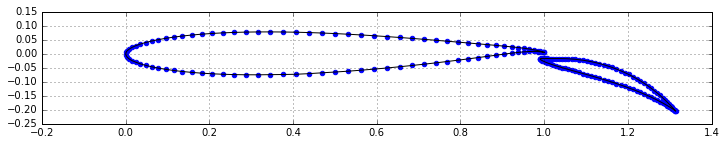

In [14]:
pyplot.figure(figsize=(12,2))
pyplot.plot(x_wing, y_wing, x_flap, y_flap,  color='k', linestyle='-', linewidth=1);
pyplot.grid(True)
panel_main, panel_flap = define_panels(x_wing, y_wing, N), define_panels(x_flap, y_flap, N)
pyplot.scatter([panel.xa for panel in panel_main], [panel.ya for panel in panel_main], color='b');
pyplot.scatter([panel.xa for panel in panel_flap], [panel.ya for panel in panel_flap], color='b');


In [15]:
u_freestream=1
alpha=0
N_wing=len(x_wing)-1
N_flap=len(x_flap)-1

In [16]:
panels_main = define_panels(x_wing, y_wing, N_wing)
panels_flap = define_panels(x_flap, y_flap, N_flap)
total_panels = numpy.concatenate((panels_main,panels_flap))

In [17]:
freestream = Freestream(1,0)
A, At = build_matrix(total_panels)
B = build_rhs(total_panels, freestream)
tars = numpy.linalg.solve(A,B)

C:\Users\55468\Anaconda3\lib\site-packages\ipykernel\__main__.py:30: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\55468\Anaconda3\lib\site-packages\ipykernel\__main__.py:31: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\55468\Anaconda3\lib\site-packages\ipykernel\__main__.py:34: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\55468\Anaconda3\lib\site-packages\ipykernel\__main__.py:35: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\55468\Anaconda3\lib\site-packages\ipykernel\__main__.py:40: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\55468\Anaconda3\lib\site-packages\ipykernel\__main__.py:20: VisibleDeprecati

In [18]:
for i, panel in enumerate(total_panels):
    panel.sigma = tars[i]
    
gamma = tars[-2:]
get_tangential_velocity(total_panels, freestream, gamma, At)
get_pressure_coefficient(total_panels, freestream)

In [19]:
val_x, val_y = 1.0, 2.0
x_min, x_max = numpy.min( [panel.xa for panel in total_panels]), numpy.max([panel.xa for panel in total_panels])
y_min, y_max = numpy.min( [panel.ya for panel in total_panels]), numpy.max([panel.ya for panel in total_panels])

x_start, x_end = x_min-val_x*(x_max-x_min), x_max+val_x*(x_max-x_min)
y_start, y_end = y_min-val_y*(y_max-y_min), y_max+val_y*(y_max-y_min)

X, Y = numpy.meshgrid(numpy.linspace(x_start, x_end, Nx), numpy.linspace(y_start, y_end, Ny))
u, v = get_velocity_field(total_panels, freestream, X, Y)
cp = 1.0 - (u**2+v**2)/freestream.u_inf**2

C:\Users\55468\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\55468\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Lift = 3.69771
Drag = 0.01079


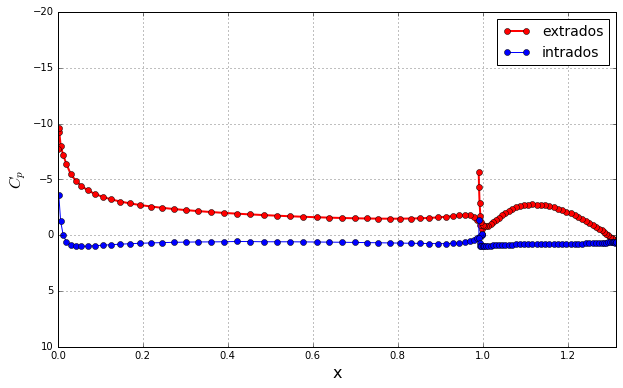

In [20]:
pyplot.figure(figsize=(10, 6))
pyplot.grid(True)
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('$C_p$', fontsize=16)

L = len(total_panels);

panel_main = total_panels[:L/2]
panel_flap = total_panels[L/2:]

val_x, val_y = 0.1, 0.2
x_min, x_max = min( panel.xa for panel in total_panels ), max( panel.xa for panel in total_panels )
cp_min, cp_max = min( panel.cp for panel in total_panels ), max( panel.cp for panel in total_panels )
x_start, x_end = x_min-val_x*(x_max-x_min), x_max+val_x*(x_max-x_min)
y_start, y_end = cp_min-val_y*(cp_max-cp_min), cp_max+val_y*(cp_max-cp_min)

pyplot.plot([panel.xc for panel in panel_main if panel.loc == 'extrados'], 
         [panel.cp for panel in panel_main if panel.loc == 'extrados'], 
         color='r', linestyle='-', linewidth=2, marker='o', markersize=6)

pyplot.plot([panel.xc for panel in panel_main if panel.loc == 'intrados'], 
         [panel.cp for panel in panel_main if panel.loc == 'intrados'], 
         color='b', linestyle='-', linewidth=1, marker='o', markersize=6)

pyplot.plot([panel.xc for panel in panel_flap if panel.loc == 'extrados'], 
         [panel.cp for panel in panel_flap if panel.loc == 'extrados'], 
         color='r', linestyle='-', linewidth=2, marker='o', markersize=6)

pyplot.plot([panel.xc for panel in panel_flap if panel.loc == 'intrados'], 
         [panel.cp for panel in panel_flap if panel.loc == 'intrados'], 
         color='b', linestyle='-', linewidth=1, marker='o', markersize=6)

pyplot.legend(['extrados', 'intrados'], loc='best', prop={'size':14})

pyplot.xlim(x_min, x_max)
pyplot.ylim(-20, 10)

pyplot.gca().invert_yaxis()


Gamma = sum(panel.length * gamma[0] for panel in panel_main)
Gamma += sum(panel.length * gamma[1] for panel in panel_flap)

L, D = 0., 0.
for panel in total_panels:
    L -= panel.cp * panel.length * math.sin(panel.beta)
    D += panel.cp * panel.length * math.cos(panel.beta)


print('Lift = %.5f' % L)
print('Drag = %.5f' % D)

In [21]:
a=numpy.zeros([2,5])
a

array([[ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.]])

In [22]:
total_panels[2].cp

-0.95570117298078139

In [23]:
total_panels[len(total_panels)/2+9].cp

C:\Users\55468\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


-0.2799183983685567

In [27]:
N2 = 150;
err = 1.

In [29]:
x_h, y_h = 1.03, -0.054 



IndexError: index 101 is out of bounds for axis 0 with size 101

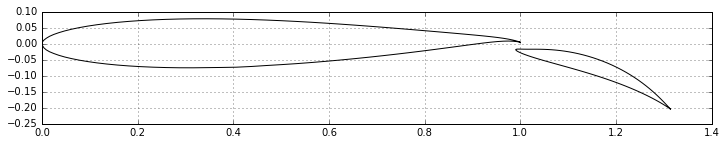

In [30]:
pyplot.figure(figsize=(12,2))
pyplot.plot(x_wing, y_wing, x_flap, y_flap,  color='k', linestyle='-', linewidth=1);
pyplot.grid(True)
panel_main, panel_flap = define_panels(x_wing, y_wing, N2), define_panels(x_flap, y_flap, N2)
pyplot.scatter([panel.xa for panel in panel_main], [panel.ya for panel in panel_main], color='y');
pyplot.scatter([panel.xa for panel in panel_flap], [panel.ya for panel in panel_flap], color='y');

pyplot.scatter([panel.xa for panel in panel_main], [panel.ya for panel in panel_main], color='y');
pyplot.scatter([panel.xa for panel in panel_flap], [panel.ya for panel in panel_flap], color='y');
pyplot.xlim(-0.5, 1.5)
pyplot.ylim(-0.25, 0.25)